## Setting Up:

In [30]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '../../')) # Add root of repo to import MBM

import pandas as pd
import warnings
from tqdm.notebook import tqdm
import re
import matplotlib.pyplot as plt
import seaborn as sns
from cmcrameri import cm
import xarray as xr
import massbalancemachine as mbm
from collections import defaultdict
import logging
import torch.nn as nn
from skorch.helper import SliceDataset
from datetime import datetime
from skorch.callbacks import EarlyStopping, LRScheduler, Checkpoint
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset
import pickle 

from scripts.helpers import *
from scripts.iceland_preprocess import *
from scripts.plots import *
from scripts.config_ICE import *
from scripts.nn_helpers import *
from scripts.xgb_helpers import *
from scripts.NN_networks import *

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

# Initialize logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')

cfg = mbm.IcelandConfig(dataPath='/home/mburlet/scratch/data/DATA_MB/WGMS/Iceland/')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
seed_all(cfg.seed)
free_up_cuda()

# Plot styles:
path_style_sheet = 'scripts/example.mplstyle'
plt.style.use(path_style_sheet)


vois_climate = [
    't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
]

vois_topographical = [
    "aspect",
    "slope",
    "hugonnet_dhdt",
    "consensus_ice_thickness",
    "millan_v",
]

In [3]:
if torch.cuda.is_available():
    print("CUDA is available")
    free_up_cuda()

    # # Try to limit CPU usage of random search
    # torch.set_num_threads(2)  # or 1
    # os.environ["OMP_NUM_THREADS"] = "1"
    # os.environ["MKL_NUM_THREADS"] = "1"
else:
    print("CUDA is NOT available")


CUDA is available


## A. Read GL data:

In [ ]:
data_wgms = pd.read_csv(cfg.dataPath + path_PMB_WGMS_csv + 'ICE_dataset_all_oggm_with_hugonnetdhdt.csv')

print('Number of glaciers:', len(data_wgms['GLACIER'].unique()))
print('Number of winter, summer and annual samples:', len(data_wgms[data_wgms.PERIOD == 'annual']) + len(data_wgms[data_wgms.PERIOD == 'winter']) + len(data_wgms[data_wgms.PERIOD == 'summer']))
print('Number of annual samples:',
      len(data_wgms[data_wgms.PERIOD == 'annual']))
print('Number of winter samples:',
      len(data_wgms[data_wgms.PERIOD == 'winter']))
print('Number of summer samples:',
      len(data_wgms[data_wgms.PERIOD == 'summer']))

data_wgms.columns

## Input data:
### Input dataset:

In [ ]:
data_wgms_test = data_wgms.copy()

# Transform data to monthly format (run or load data):
paths = {
    'csv_path': cfg.dataPath + path_PMB_WGMS_csv,
    'era5_climate_data': cfg.dataPath + path_ERA5_raw + 'era5_monthly_averaged_data_ICECH.nc',
    'geopotential_data': cfg.dataPath + path_ERA5_raw + 'era5_geopotential_pressure_ICECH.nc'
}

RUN = False
dataloader_gl = process_or_load_data(run_flag=RUN,
                                     df=data_wgms_test,
                                     paths=paths,
                                     cfg=cfg,
                                     vois_climate=vois_climate,
                                     vois_topographical=vois_topographical,
                                     output_file='ICE_dataset_monthly_full_with_hugonnetdhdt.csv')
data_monthly = dataloader_gl.data

display(data_monthly.head(2))
"""
data_monthly['GLWD_ID'] = data_monthly.apply(
    lambda x: mbm.data_processing.utils.get_hash(f"{x.GLACIER}_{x.YEAR}"),
    axis=1)
data_monthly['GLWD_ID'] = data_monthly['GLWD_ID'].astype(str)

dataloader_gl = mbm.dataloader.DataLoader(cfg,
                                          data=data_monthly,
                                          random_seed=cfg.seed,
                                          meta_data_columns=cfg.metaData)
"""

## Blocking on glaciers:

In [ ]:
# These are the two icecaps to the west
Langjokul = dataloader_gl.data[
    (dataloader_gl.data['POINT_LON'] < -19.4) & 
    (dataloader_gl.data['POINT_LAT'] > 64.3)
]['GLACIER'].unique()
display(Langjokul)

In [ ]:
test_glaciers = ['Hagafellsjoekull West', 'RGI60-06.00303', 'Langjoekull Ice Cap',
       'RGI60-06.00302', 'Hagafellsjoekull East (Langjoekull S Dome)',
       'RGI60-06.00294', 'RGI60-06.00292', 'RGI60-06.00301',
       'RGI60-06.00311', 'RGI60-06.00305', 'RGI60-06.00306',
       'RGI60-06.00296']

# Ensure all test glaciers exist in the dataset
existing_glaciers = set(dataloader_gl.data.GLACIER.unique())
missing_glaciers = [g for g in test_glaciers if g not in existing_glaciers]

if missing_glaciers:
    print(
        f"Warning: The following test glaciers are not in the dataset: {missing_glaciers}"
    )

# Define training glaciers
train_glaciers = [i for i in existing_glaciers if i not in test_glaciers]
data_test = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(test_glaciers)]

# Statistics prints
print('Size of test data:', len(data_test))
data_train = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(
    train_glaciers)]
print('Size of train data:', len(data_train))
if len(data_train) == 0:
    print("Warning: No training data available!")
else:
    test_perc = (len(data_test) / len(data_train)) * 100
    print('Percentage of test size: {:.2f}%'.format(test_perc))

## CV Splits
splits, test_set, train_set = get_CV_splits(dataloader_gl,
                                            test_split_on='GLACIER',
                                            test_splits=test_glaciers,
                                            random_state=cfg.seed)
    
print('Train glaciers: ({}) {}'.format(len(train_set['splits_vals']),
                                      train_set['splits_vals']))
print('Test glaciers: ({}) {}'.format(len(test_set['splits_vals']),
                                      test_set['splits_vals']))

In [ ]:
# Validation and train split:
data_train = train_set['df_X']
data_train['y'] = train_set['y']
dataloader = mbm.dataloader.DataLoader(cfg, data=data_train)

train_itr, val_itr = dataloader.set_train_test_split(test_size=0.2)

# Get all indices of the training and valing dataset at once from the iterators. Once called, the iterators are empty.
train_indices, val_indices = list(train_itr), list(val_itr)

df_X_train = data_train.iloc[train_indices]
y_train = df_X_train['POINT_BALANCE'].values

# Get val set
df_X_val = data_train.iloc[val_indices]
y_val = df_X_val['POINT_BALANCE'].values

## B. CH Transfer

In [4]:
data_CH = pd.read_csv('/home/mburlet/scratch/data/DATA_MB/CH_wgms_dataset_all_04_06_oggm.csv')
data_ICE = pd.read_csv('/home/mburlet/scratch/data/DATA_MB/WGMS/Iceland/csv/ICE_dataset_all_oggm_with_hugonnetdhdt.csv')

# Drop Nan entries in hugonnetdhdt of Iceland dataset
data_ICE = data_ICE.dropna(subset=data_ICE.columns.drop('DATA_MODIFICATION'))
display(data_CH.columns)
display(data_ICE)

display(data_ICE.columns)

data_CH = data_CH.drop(['aspect_sgi', 'slope_sgi', 'topo_sgi'], axis=1)

display(data_CH.columns)

# Merge CH with ICE
data_ICE_CH = pd.concat([data_ICE, data_CH], axis=0).reset_index(drop=True)

display(data_ICE_CH.head(2))

display(len(data_ICE_CH['GLACIER'].unique()))

Index(['YEAR', 'POINT_ID', 'GLACIER', 'FROM_DATE', 'TO_DATE', 'POINT_LAT',
       'POINT_LON', 'POINT_ELEVATION', 'POINT_BALANCE', 'PERIOD', 'RGIId',
       'aspect', 'slope', 'topo', 'hugonnet_dhdt', 'consensus_ice_thickness',
       'millan_v', 'aspect_sgi', 'slope_sgi', 'topo_sgi'],
      dtype='object')

,POINT_ELEVATION,POINT_LAT,POINT_LON,DATA_MODIFICATION,FROM_DATE,TO_DATE,POINT_BALANCE,PERIOD,YEAR,RGIId,aspect,slope,topo,hugonnet_dhdt,consensus_ice_thickness,millan_v,GLACIER,POINT_ID
0,1049.6,64.790063,-18.595688,NaN,19880920,19890922,0.45,annual,1989.0,RGI60-06.00234,158.071560,2.508572,1034.505493,-0.959929,270.877716,25.446609,Thjorsarjoekull (Hofsjoekull E),Thjorsarjoekull (Hofsjoekull E)_1989.0_annual_...
1,1049.4,64.790063,-18.595688,NaN,19890922,19900916,-0.80,annual,1990.0,RGI60-06.00234,158.071560,2.508572,1034.505493,-0.959929,270.877716,25.446609,Thjorsarjoekull (Hofsjoekull E),Thjorsarjoekull (Hofsjoekull E)_1990.0_annual_...
2,1049.1,64.790063,-18.595688,NaN,19900916,19910912,-2.37,annual,1991.0,RGI60-06.00234,158.071560,2.508572,1034.505493,-0.959929,270.877716,25.446609,Thjorsarjoekull (Hofsjoekull E),Thjorsarjoekull (Hofsjoekull E)_1991.0_annual_...
3,1048.9,64.790063,-18.595688,NaN,19910912,19920920,0.65,annual,1992.0,RGI60-06.00234,158.071560,2.508572,1034.505493,-0.959929,270.877716,25.446609,Thjorsarjoekull (Hofsjoekull E),Thjorsarjoekull (Hofsjoekull E)_1992.0_annual_...
4,1048.6,64.790063,-18.595688,NaN,19920920,19930917,-0.06,annual,1993.0,RGI60-06.00234,158.071560,2.508572,1034.505493,-0.959929,270.877716,25.446609,Thjorsarjoekull (Hofsjoekull E),Thjorsarjoekull (Hofsjoekull E)_1993.0_annual_...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6544,1697.0,64.793858,-18.843883,NaN,20181008,20190430,2.47,winter,2019.0,RGI60-06.00234,129.234952,3.695461,1692.968628,-0.096206,320.101654,48.503876,Thjorsarjoekull (Hofsjoekull E),Thjorsarjoekull (Hofsjoekull E)_2019.0_winter_...
6545,1697.0,64.793858,-18.843883,NaN,20191106,20200429,2.04,winter,2020.0,RGI60-06.00234,129.234952,3.695461,1692.968628,-0.096206,320.101654,48.503876,Thjorsarjoekull (Hofsjoekull E),Thjorsarjoekull (Hofsjoekull E)_2020.0_winter_...
6546,1697.0,64.793858,-18.843883,NaN,20201010,20210503,1.93,winter,2021.0,RGI60-06.00234,129.234952,3.695461,1692.968628,-0.096206,320.101654,48.503876,Thjorsarjoekull (Hofsjoekull E),Thjorsarjoekull (Hofsjoekull E)_2021.0_winter_...
6547,1697.0,64.793858,-18.843883,NaN,20211021,20220427,2.74,winter,2022.0,RGI60-06.00234,129.234952,3.695461,1692.968628,-0.096206,320.101654,48.503876,Thjorsarjoekull (Hofsjoekull E),Thjorsarjoekull (Hofsjoekull E)_2022.0_winter_...


Index(['POINT_ELEVATION', 'POINT_LAT', 'POINT_LON', 'DATA_MODIFICATION',
       'FROM_DATE', 'TO_DATE', 'POINT_BALANCE', 'PERIOD', 'YEAR', 'RGIId',
       'aspect', 'slope', 'topo', 'hugonnet_dhdt', 'consensus_ice_thickness',
       'millan_v', 'GLACIER', 'POINT_ID'],
      dtype='object')

Index(['YEAR', 'POINT_ID', 'GLACIER', 'FROM_DATE', 'TO_DATE', 'POINT_LAT',
       'POINT_LON', 'POINT_ELEVATION', 'POINT_BALANCE', 'PERIOD', 'RGIId',
       'aspect', 'slope', 'topo', 'hugonnet_dhdt', 'consensus_ice_thickness',
       'millan_v'],
      dtype='object')

,POINT_ELEVATION,POINT_LAT,POINT_LON,DATA_MODIFICATION,FROM_DATE,TO_DATE,POINT_BALANCE,PERIOD,YEAR,RGIId,aspect,slope,topo,hugonnet_dhdt,consensus_ice_thickness,millan_v,GLACIER,POINT_ID
0,1049.6,64.790063,-18.595688,NaN,19880920,19890922,0.45,annual,1989.0,RGI60-06.00234,158.07156,2.508572,1034.505493,-0.959929,270.877716,25.446609,Thjorsarjoekull (Hofsjoekull E),Thjorsarjoekull (Hofsjoekull E)_1989.0_annual_...
1,1049.4,64.790063,-18.595688,NaN,19890922,19900916,-0.80,annual,1990.0,RGI60-06.00234,158.07156,2.508572,1034.505493,-0.959929,270.877716,25.446609,Thjorsarjoekull (Hofsjoekull E),Thjorsarjoekull (Hofsjoekull E)_1990.0_annual_...


86

In [5]:
data_CH_ICE_test = data_ICE_CH.copy()

display(data_CH_ICE_test.shape)
display(data_CH_ICE_test.head(2))

# Initialize logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')

# Transform data to monthly format (run or load data):
paths = {
    'csv_path': cfg.dataPath + path_PMB_WGMS_csv,
    'era5_climate_data': cfg.dataPath + path_ERA5_raw + 'era5_monthly_averaged_data_ICECH.nc',
    'geopotential_data': cfg.dataPath + path_ERA5_raw + 'era5_geopotential_pressure_ICECH.nc'
}

RUN = True
dataloader_gl = process_or_load_data(run_flag=RUN,
                                     df=data_CH_ICE_test,
                                     paths=paths,
                                     cfg=cfg,
                                     vois_climate=vois_climate,
                                     vois_topographical=vois_topographical,
                                     output_file= 'CH_ICE_wgms_dataset_monthly_full_with_hugonnetdhdt.csv')
data_monthly_CH_ICE = dataloader_gl.data

display(data_monthly_CH_ICE.head(2))

(39288, 18)

,POINT_ELEVATION,POINT_LAT,POINT_LON,DATA_MODIFICATION,FROM_DATE,TO_DATE,POINT_BALANCE,PERIOD,YEAR,RGIId,aspect,slope,topo,hugonnet_dhdt,consensus_ice_thickness,millan_v,GLACIER,POINT_ID
0,1049.6,64.790063,-18.595688,NaN,19880920,19890922,0.45,annual,1989.0,RGI60-06.00234,158.07156,2.508572,1034.505493,-0.959929,270.877716,25.446609,Thjorsarjoekull (Hofsjoekull E),Thjorsarjoekull (Hofsjoekull E)_1989.0_annual_...
1,1049.4,64.790063,-18.595688,NaN,19890922,19900916,-0.80,annual,1990.0,RGI60-06.00234,158.07156,2.508572,1034.505493,-0.959929,270.877716,25.446609,Thjorsarjoekull (Hofsjoekull E),Thjorsarjoekull (Hofsjoekull E)_1990.0_annual_...


2025-07-07 13:14:51,055 - INFO - Number of annual and seasonal samples: 39288
2025-07-07 13:14:51,058 - INFO - Running on 86 glaciers:
['Thjorsarjoekull (Hofsjoekull E)' 'Breidamerkurjoekull' 'Dyngjujoekull'
 'RGI60-06.00328' 'Tungnaarjoekull' 'Hagafellsjoekull West'
 'Eyjabakkajoekull' 'RGI60-06.00303' 'Langjoekull Ice Cap'
 'Koeldukvislarjoekull' 'Oeldufellsjoekull' 'Skeidararjoekull'
 'Slettjoekull West' 'RGI60-06.00466' 'RGI60-06.00411' 'RGI60-06.00302'
 'RGI60-06.00359' 'RGI60-06.00340' 'Bruarjoekull'
 'Blagnipujoekull (Hofsjoekull SW)' 'RGI60-06.00238' 'RGI60-06.00320'
 'Hagafellsjoekull East (Langjoekull S Dome)' 'RGI60-06.00342'
 'RGI60-06.00480' 'RGI60-06.00465' 'RGI60-06.00294' 'RGI60-06.00292'
 'RGI60-06.00232' 'RGI60-06.00478' 'Mulajoekull' 'RGI60-06.00301'
 'RGI60-06.00413' 'RGI60-06.00311' 'RGI60-06.00350' 'RGI60-06.00476'
 'RGI60-06.00228' 'RGI60-06.00409' 'RGI60-06.00349' 'RGI60-06.00422'
 'RGI60-06.00305' 'RGI60-06.00425' 'RGI60-06.00306' 'RGI60-06.00479'
 'RGI60-06.00

2025-07-07 13:14:51,118 - INFO - Number of annual samples: 10189
2025-07-07 13:14:51,123 - INFO - Number of winter samples: 29099
2025-07-07 13:14:51,124 - INFO - Adding climate features...
2025-07-07 13:15:13,704 - INFO - Converting to monthly resolution...
2025-07-07 13:16:40,527 - INFO - Number of monthly rows: 346891
2025-07-07 13:16:40,528 - INFO - Columns in the dataset: Index(['YEAR', 'POINT_LON', 'POINT_LAT', 'POINT_BALANCE', 'ALTITUDE_CLIMATE',
       'ELEVATION_DIFFERENCE', 'POINT_ELEVATION', 'RGIId', 'POINT_ID', 'ID',
       'N_MONTHS', 'MONTHS', 'PERIOD', 'GLACIER', 'aspect', 'slope',
       'hugonnet_dhdt', 'consensus_ice_thickness', 'millan_v', 't2m', 'tp',
       'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'],
      dtype='object')
2025-07-07 13:16:47,787 - INFO - Processed data saved to: /home/mburlet/scratch/data/DATA_MB/WGMS/Iceland/csv/CH_ICE_wgms_dataset_monthly_full_with_hugonnetdhdt.csv


,YEAR,POINT_LON,POINT_LAT,POINT_BALANCE,ALTITUDE_CLIMATE,ELEVATION_DIFFERENCE,POINT_ELEVATION,RGIId,POINT_ID,ID,...,millan_v,t2m,tp,slhf,sshf,ssrd,fal,str,u10,v10
0,1989.0,-18.595688,64.790063,0.45,1094.738918,-45.138918,1049.6,RGI60-06.00234,Thjorsarjoekull (Hofsjoekull E)_1989.0_annual_...,0,...,25.446609,-4.787933,0.003747,198886.0,590722.0,3990646.0,0.84564,-1779436.0,-0.590102,0.603381
1,1989.0,-18.595688,64.790063,0.45,1094.738918,-45.138918,1049.6,RGI60-06.00234,Thjorsarjoekull (Hofsjoekull E)_1989.0_annual_...,0,...,25.446609,-5.262054,0.003766,306376.0,576896.0,883468.0,0.84690,-1458576.0,0.129348,2.214950


In [6]:
test_glaciers = list(data_ICE['GLACIER'].unique())

# Ensure all test glaciers exist in the dataset
existing_glaciers = set(dataloader_gl.data.GLACIER.unique())
missing_glaciers = [g for g in test_glaciers if g not in existing_glaciers]

if missing_glaciers:
    print(
        f"Warning: The following test glaciers are not in the dataset: {missing_glaciers}"
    )

# Define training glaciers correctly
train_glaciers = list(data_CH['GLACIER'].unique())

data_test = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(test_glaciers)]

# Statistics prints
print('Size of test data:', len(data_test))
data_train = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(
    train_glaciers)]
print('Size of train data:', len(data_train))
if len(data_train) == 0:
    print("Warning: No training data available!")
else:
    test_perc = (len(data_test) / len(data_train)) * 100
    print('Percentage of test size: {:.2f}%'.format(test_perc))

## CV Splits
splits, test_set, train_set = get_CV_splits(dataloader_gl,
                                            test_split_on='GLACIER',
                                            test_splits=test_glaciers,
                                            random_state=cfg.seed)
    
print('Train glaciers: ({}) {}'.format(len(train_set['splits_vals']),
                                      train_set['splits_vals']))
print('Test glaciers: ({}) {}'.format(len(test_set['splits_vals']),
                                      test_set['splits_vals']))

Size of test data: 56209
Size of train data: 290682
Percentage of test size: 19.34%
Train glaciers: (39) ['adler' 'albigna' 'aletsch' 'allalin' 'basodino' 'cantun' 'chessjen'
 'clariden' 'corbassiere' 'corvatsch' 'damma' 'findelen' 'forno' 'gietro'
 'gorner' 'gries' 'hohlaub' 'joeri' 'limmern' 'morteratsch' 'murtel'
 'oberaar' 'otemma' 'pizol' 'plainemorte' 'plattalva' 'rhone' 'sanktanna'
 'sardona' 'schwarzbach' 'schwarzberg' 'sexrouge' 'silvretta'
 'taelliboden' 'tiefen' 'tortin' 'tsanfleuron' 'vorab' 'witenwasseren']
Test glaciers: (47) ['Thjorsarjoekull (Hofsjoekull E)' 'Breidamerkurjoekull' 'Dyngjujoekull'
 'RGI60-06.00328' 'Tungnaarjoekull' 'Hagafellsjoekull West'
 'Eyjabakkajoekull' 'RGI60-06.00303' 'Langjoekull Ice Cap'
 'Koeldukvislarjoekull' 'Oeldufellsjoekull' 'Skeidararjoekull'
 'Slettjoekull West' 'RGI60-06.00466' 'RGI60-06.00411' 'RGI60-06.00302'
 'RGI60-06.00359' 'RGI60-06.00340' 'Bruarjoekull'
 'Blagnipujoekull (Hofsjoekull SW)' 'RGI60-06.00238' 'RGI60-06.00320'
 'Hagaf

In [7]:
# Validation and train split:
data_train = train_set['df_X']
data_train['y'] = train_set['y']
dataloader = mbm.dataloader.DataLoader(cfg, data=data_train)

train_itr, val_itr = dataloader.set_train_test_split(test_size=0.2)

# Get all indices of the training and valing dataset at once from the iterators. Once called, the iterators are empty.
train_indices, val_indices = list(train_itr), list(val_itr)

df_X_train = data_train.iloc[train_indices]
y_train = df_X_train['POINT_BALANCE'].values

# Get val set
df_X_val = data_train.iloc[val_indices]
y_val = df_X_val['POINT_BALANCE'].values

## Neural Network:

In [8]:
def create_period_indicator(df):
    """Create numerical PERIOD_INDICATOR feature"""
    df = df.copy()
    df['PERIOD_INDICATOR'] = df['PERIOD'].map({'annual': 0, 'winter': 1})
    return df

# Apply to all datasets
df_X_train = create_period_indicator(df_X_train)
df_X_val = create_period_indicator(df_X_val)
test_set['df_X'] = create_period_indicator(test_set['df_X'])

print("PERIOD_INDICATOR created:")
print("Annual (0):", (df_X_train['PERIOD_INDICATOR'] == 0).sum())
print("Winter (1):", (df_X_train['PERIOD_INDICATOR'] == 1).sum())
print("Original PERIOD column preserved:", df_X_train['PERIOD'].unique())

PERIOD_INDICATOR created:
Annual (0): 70279
Winter (1): 162367
Original PERIOD column preserved: ['annual' 'winter']


In [9]:
features_topo = [
    'ELEVATION_DIFFERENCE',
] + list(vois_topographical)

# Add PERIOD_INDICATOR as a feature (keeping original PERIOD for plotting)
feature_columns = features_topo + list(vois_climate) + ['PERIOD_INDICATOR']

cfg.setFeatures(feature_columns)

all_columns = feature_columns + cfg.fieldsNotFeatures

# Because CH has some extra columns, we need to cut those
df_X_train_subset = df_X_train[all_columns]
df_X_val_subset = df_X_val[all_columns]
df_X_test_subset = test_set['df_X'][all_columns]

print('Shape of training dataset:', df_X_train_subset.shape)
print('Shape of validation dataset:', df_X_val_subset.shape)
print('Shape of testing dataset:', df_X_test_subset.shape)
print('Running with features:', feature_columns)

assert all(train_set['df_X'].POINT_BALANCE == train_set['y'])

Shape of training dataset: (232646, 29)
Shape of validation dataset: (58036, 29)
Shape of testing dataset: (56209, 29)
Running with features: ['ELEVATION_DIFFERENCE', 'aspect', 'slope', 'hugonnet_dhdt', 'consensus_ice_thickness', 'millan_v', 't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10', 'PERIOD_INDICATOR']


In [11]:
# Check the current Iceland feature order
print("Current Iceland feature order:")
for i, feature in enumerate(feature_columns):
    print(f"{i}: {feature}")

Current Iceland feature order:
0: ELEVATION_DIFFERENCE
1: aspect
2: slope
3: hugonnet_dhdt
4: consensus_ice_thickness
5: millan_v
6: t2m
7: tp
8: slhf
9: sshf
10: ssrd
11: fal
12: str
13: u10
14: v10
15: PERIOD_INDICATOR


### Initialise network:

In [ ]:
"""
# Open grid_search results
gs_results = pd.read_csv(
        'logs/nn_param_search_progress_2025-06-06.csv').sort_values(
        by='valid_loss', ascending=True)
best_params = gs_results.iloc[0].to_dict()

print('Best parameters from grid search:')
for key, value in best_params.items():
    if key not in ['valid_loss', 'train_loss']:
        print(f"{key}: {value}")

gs_results.head(10)
"""


In [12]:
early_stop = EarlyStopping(
    monitor='valid_loss',
    patience=10,    # Increase from 10
    threshold=1e-4,  # Optional: stop only when improvement is very small
)

lr_scheduler_cb = LRScheduler(policy=ReduceLROnPlateau,
                              monitor='valid_loss',
                              mode='min',
                              factor=0.5,   # Reduced more aggressively (was 0.5)
                              patience=5,   # Reduced patience (was 5)
                              threshold=0.01,  # Reduced threshold (was 0.01)
                              threshold_mode='rel',
                              verbose=True)

dataset = dataset_val = None  # Initialized hereafter
def my_train_split(ds, y=None, **fit_params):
    return dataset, dataset_val


# param_init = {'device': 'cuda:0'}
param_init = {'device': 'cpu'}  # Use CPU for training
nInp = len(feature_columns)


custom_params = {
    'lr': 0.001,    # reduced from 0.001
    'batch_size': 128,  # Increased from 128
    'module__layer0': 128,
    'module__layer1': 96,
    'module__layer2': 64,
    'module__layer3': 32,
    'module__dropout': 0.2,
    'optimizer':torch.optim.Adam
}

params = custom_params

args = {
    'module': PeriodSpecificNetBigger,
    'nbFeatures': nInp,
    'module__input_dim': nInp,
    'module__hidden_dim_0': params['module__layer0'],
    'module__hidden_dim_1': params['module__layer1'], 
    'module__hidden_dim_2': params['module__layer2'],
    'module__hidden_dim_3': params['module__layer3'],
    'train_split': my_train_split,
    'batch_size': params['batch_size'],
    'verbose': 1,
    'iterator_train__shuffle': True,
    'lr': params['lr'],
    'max_epochs': 300,
    'optimizer': params['optimizer'],
    'callbacks': [
        ('early_stop', early_stop),
        ('lr_scheduler', lr_scheduler_cb),
    ]
}
custom_nn = mbm.models.CustomNeuralNetRegressor(cfg, **args, **param_init)

### Create datasets:

In [13]:
features, metadata = custom_nn._create_features_metadata(df_X_train_subset)

features_val, metadata_val = custom_nn._create_features_metadata(
    df_X_val_subset)

# Define the dataset for the NN
dataset = mbm.data_processing.AggregatedDataset(cfg,
                                                features=features,
                                                metadata=metadata,
                                                targets=y_train)
dataset = mbm.data_processing.SliceDatasetBinding(SliceDataset(dataset, idx=0),
                                                  SliceDataset(dataset, idx=1))
print("train:", dataset.X.shape, dataset.y.shape)

dataset_val = mbm.data_processing.AggregatedDataset(cfg,
                                                    features=features_val,
                                                    metadata=metadata_val,
                                                    targets=y_val)
dataset_val = mbm.data_processing.SliceDatasetBinding(
    SliceDataset(dataset_val, idx=0), SliceDataset(dataset_val, idx=1))
print("validation:", dataset_val.X.shape, dataset_val.y.shape)

train: (26686,) (26686,)
validation: (6672,) (6672,)


### Train custom model:

In [ ]:
TRAIN = False
if TRAIN:
    custom_nn.seed_all()

    print("Training the model...")
    print('Model parameters:')
    for key, value in args.items():
        print(f"{key}: {value}")
    custom_nn.fit(dataset.X, dataset.y)
    # The dataset provided in fit is not used as the datasets are overwritten in the provided train_split function

    # Generate filename with current date
    current_date = datetime.now().strftime("%Y-%m-%d")
    model_filename = f"nn_model_{current_date}"

    plot_training_history(custom_nn, skip_first_n=5)

    # After Training: Best weights are already loaded
    # Save the model
    custom_nn.save_model(model_filename)
    
    # save params dic
    params_filename = f"nn_params_{current_date}.pkl"

    with open(f"models/{params_filename}", "wb") as f:
        pickle.dump(args, f)

else:
    # Load model and set to CPU
    model_filename = "nn_model_2025-07-07_PeriodSpecificNet_bigger.pt"  # Replace with actual date if needed
    loaded_model = mbm.models.CustomNeuralNetRegressor.load_model(
        cfg,
        model_filename,
        **{
            **args,
            **param_init
        },
    )
    loaded_model = loaded_model.set_params(device='cpu')
    loaded_model = loaded_model.to('cpu')

### Load model and make predictions:

In [15]:
# Create features and metadata
features_test, metadata_test = loaded_model._create_features_metadata(
    df_X_test_subset)

# Ensure all tensors are on CPU if they are torch tensors
if hasattr(features_test, 'cpu'):
    features_test = features_test.cpu()

# Ensure targets are also on CPU
targets_test = test_set['y']
if hasattr(targets_test, 'cpu'):
    targets_test = targets_test.cpu()

# Create the dataset
dataset_test = mbm.data_processing.AggregatedDataset(cfg,
                                                     features=features_test,
                                                     metadata=metadata_test,
                                                     targets=targets_test)

dataset_test = [
    SliceDataset(dataset_test, idx=0),
    SliceDataset(dataset_test, idx=1)
]

# Make predictions aggr to meas ID
y_pred = loaded_model.predict(dataset_test[0])
y_pred_agg = loaded_model.aggrPredict(dataset_test[0])

batchIndex = np.arange(len(y_pred_agg))
y_true = np.array([e for e in dataset_test[1][batchIndex]])

# Calculate scores
score = loaded_model.score(dataset_test[0], dataset_test[1])
mse, rmse, mae, pearson = loaded_model.evalMetrics(y_pred, y_true)

# Aggregate predictions
id = dataset_test[0].dataset.indexToId(batchIndex)
data = {
    'target': [e[0] for e in dataset_test[1]],
    'ID': id,
    'pred': y_pred_agg
}
grouped_ids = pd.DataFrame(data)

# Add period
periods_per_ids = df_X_test_subset.groupby('ID')['PERIOD'].first()
grouped_ids = grouped_ids.merge(periods_per_ids, on='ID')

# Add glacier name
glacier_per_ids = df_X_test_subset.groupby('ID')['GLACIER'].first()
grouped_ids = grouped_ids.merge(glacier_per_ids, on='ID')

# Add YEAR
years_per_ids = df_X_test_subset.groupby('ID')['YEAR'].first()
grouped_ids = grouped_ids.merge(years_per_ids, on='ID')

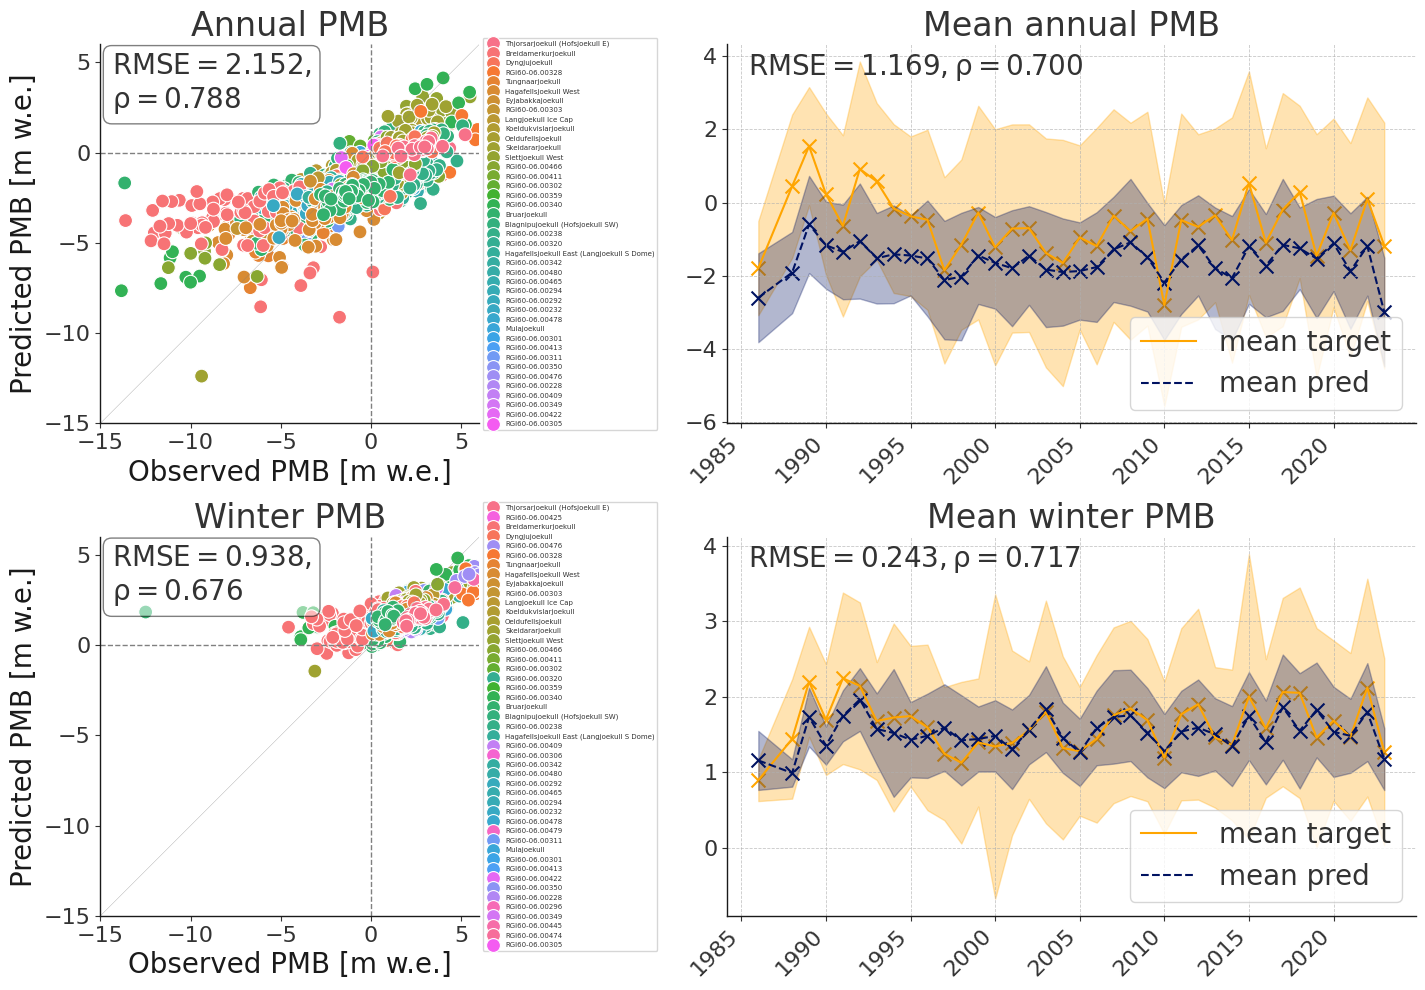

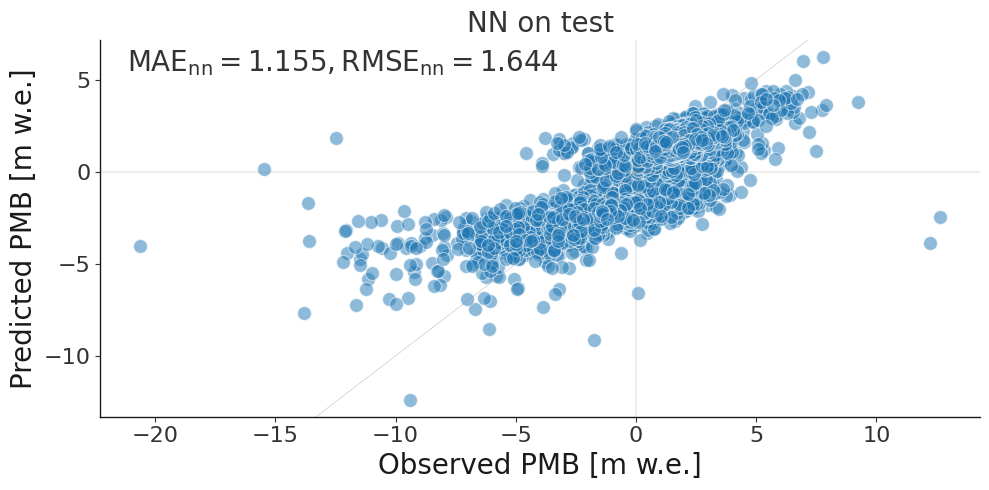

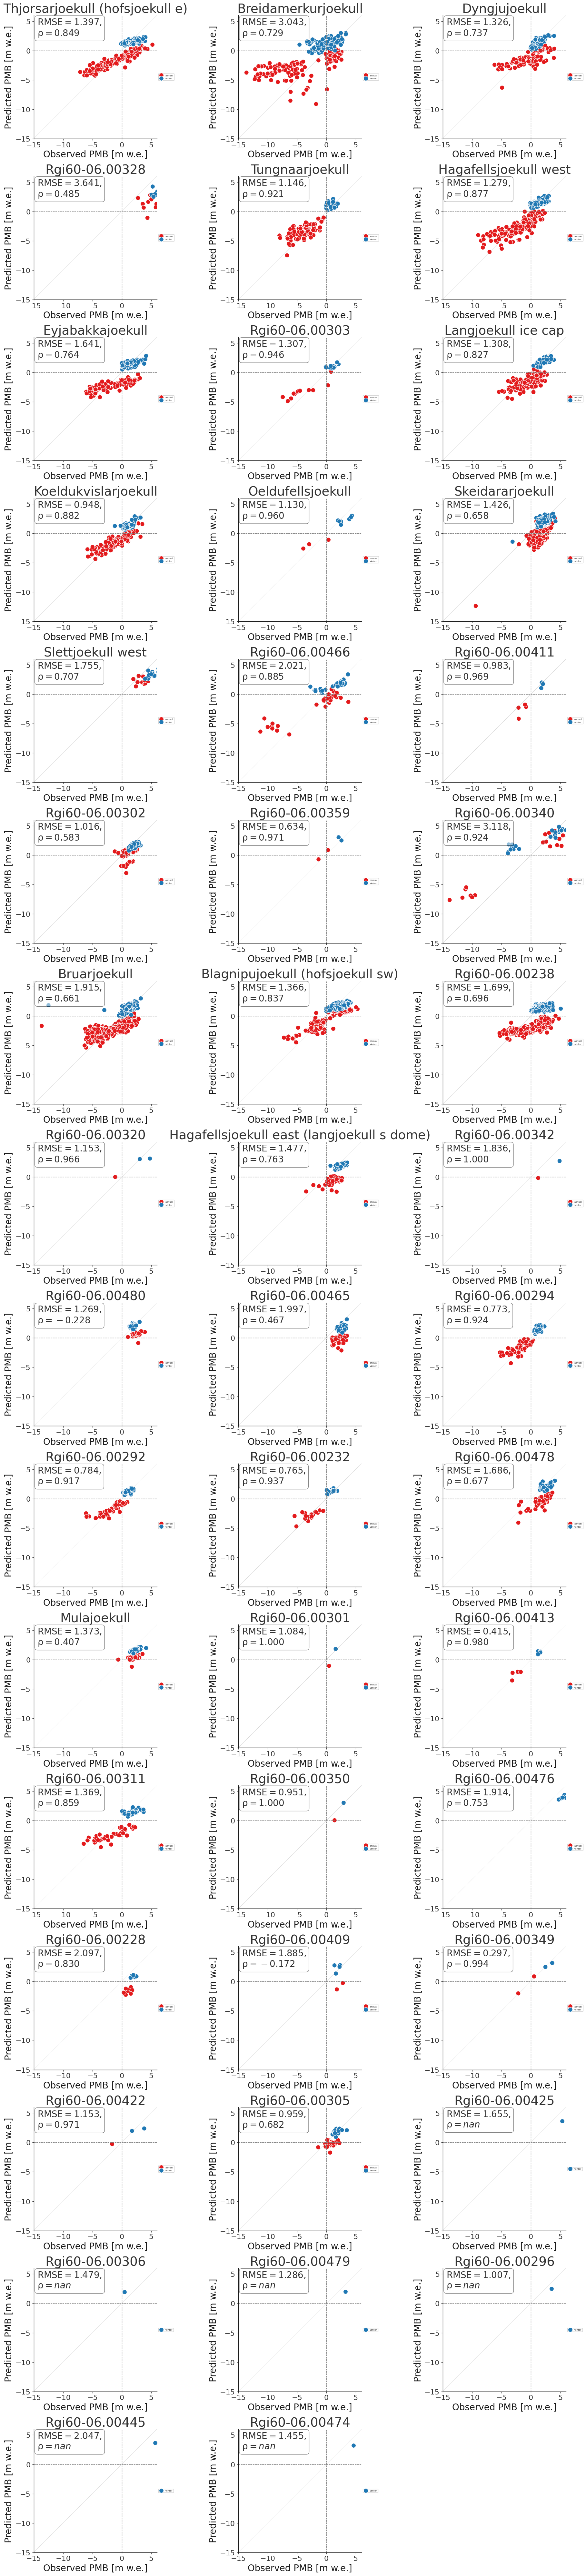

In [31]:
PlotPredictions_NN(grouped_ids)
predVSTruth_all(grouped_ids, mae, rmse, title='NN on test')
PlotIndividualGlacierPredVsTruth(grouped_ids, base_figsize=(20, 15))